In [49]:
import igraph as ig
import networkx as nx
import pandas as pd
import numpy as np
import re
import swifter

from sklearn import preprocessing
from sklearn.model_selection import cross_validate
import lightgbm as lgbm

from settings import file_names
from graph import make_friends_graph, make_user_business_bipartite_graph

In [50]:
# Helper Functions
# A helper funtion to assign communities
def assign_communities(community, df, name, G):
    # Create a new df
    df = df.copy()
    
    # Create a new column for communities
    df[name] = 0
    
    for i, com in enumerate(community):
        
        # Get node indices
        com = G.vs[com]['name']
        
        mask = df['user_id'].isin(com)
        df.loc[mask, name] = i 
        
    return df

In [51]:
# Read Data
df = pd.read_csv(file_names['toronto_reviews_without_text'])
df_biz = pd.read_csv(file_names['toronto_businesses'])

G_users = make_friends_graph('igraph')

# 1. Feature Engineering

## 1.1 Business

In [52]:
# Select relevant columns
cols = ['business_id', 'latitude', 'longitude', 'stars', 'review_count', 'attributes',
       'categories']
df_biz = df_biz[cols]

# Clean the attributes column - Undone
df_biz['attributes'] = df_biz['attributes'].map(eval, na_action='ignore')
df_biz = df_biz.drop('attributes', axis=1)

# Clean the categories column
df_biz['categories'] = df_biz['categories'].str.split(', ')

# Keep only categories that have at least 200 samples
temp = df_biz.pop('categories').explode()
temp = pd.crosstab(temp.index, temp)
mask = temp.sum(axis=0)
mask = (mask[mask>=200]).index
df_biz = pd.concat([df_biz, temp[mask]], axis=1)

## 1.2 Users

In [53]:
# Community Detection - infomap
c_infomap = G_users.community_infomap()
df_users = pd.DataFrame({'user_id':G_users.vs['name']})
df_users = assign_communities(c_infomap, df_users, 'infomap', G_users)

# Use G_users.vs['name'] to access indices

## 1.3 Reviews

In [54]:
# Create a graph to the disk - Uncomment it if you dont have the file yet
#g = nx.Graph()
#g.add_nodes_from(df.user_id.unique(), bipartite=0)
#g.add_nodes_from(df.business_id.unique(), bipartite=1)

#g.add_weighted_edges_from([(user, business, rating) for user, business, rating
#                           in zip(df.user_id, df.business_id, df.rating)])

#nx.write_graphml(g,'Toronto_data//review_graph.graphml')

# Read the saved review graph
G_review = ig.read('Toronto_data//review_graph.graphml',format="graphml")

# Use G_review.vs['id'] to access indices

In [55]:
# Some graph attributes
att = {'weighted_centrality':G_review.strength(weights='weight'),
       'eigenvector_centrality':G_review.eigenvector_centrality(weights='weight'),
       'pagerank': G_review.pagerank(weights='weight')}

att = pd.DataFrame(att)
att['index'] = G_review.vs['id']
att['index'] = att['index']
df = df.merge(att, left_on='business_id', right_on='index', how='left')
df = df.merge(att, left_on='user_id', right_on='index', how='left')

df = df.drop(['index_y', 'index_x'], axis=1)

## 1.4 Join everything together

In [68]:
data = df.merge(df_biz, on='business_id', how='left')
data = data.merge(df_users, on='user_id', how='left')

# Sort the dataframe
data = data.sort_values('date')

# Encode business ids
le = preprocessing.LabelEncoder()
data['business_id'] = le.fit_transform(data['business_id'])
data['user_id'] = le.fit_transform(data['user_id'])

In [69]:
# Separate the training and validation set
n_train = int(0.8*data.shape[0])

data_train = data.iloc[:n_train]
data_val = data.iloc[n_train:]

data_train = data_train.sort_values('user_id')
data_val = data_val.sort_values('user_id')

# 2. Modeling

## 2.1 Ranker

In [ ]:
# Create X and y
X_train = data_train.drop(['date', 'rating', 'user_id', 'longitude', 'latitude'], axis=1)
y_train = data_train['rating']
q_train = data_train.groupby('user_id')['rating'].count().values

X_val = data_val.drop(['date', 'rating', 'user_id', 'longitude', 'latitude'], axis=1)
y_val = data_val['rating']
q_val = data_val.groupby('user_id')['rating'].count().values

In [60]:
model = lgbm.LGBMRanker(n_estimators=1000, n_jobs=-1, learning_rate=0.1, silent=True)

In [62]:
model.fit(X_train, y_train, group=q_train, eval_set=[(X_val, y_val)], eval_group=[q_val], eval_metric='auc', verbose=100)

[100]	valid_0's auc: 1	valid_0's ndcg@1: 0.86807
[200]	valid_0's auc: 1	valid_0's ndcg@1: 0.869312
[300]	valid_0's auc: 1	valid_0's ndcg@1: 0.868862
[400]	valid_0's auc: 1	valid_0's ndcg@1: 0.869565
[500]	valid_0's auc: 1	valid_0's ndcg@1: 0.86978
[600]	valid_0's auc: 1	valid_0's ndcg@1: 0.868451
[700]	valid_0's auc: 1	valid_0's ndcg@1: 0.867273
[800]	valid_0's auc: 1	valid_0's ndcg@1: 0.864681
[900]	valid_0's auc: 1	valid_0's ndcg@1: 0.86256
[1000]	valid_0's auc: 1	valid_0's ndcg@1: 0.862213


LGBMRanker(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
           importance_type='split', learning_rate=0.1, max_depth=-1,
           min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
           n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
           random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
           subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

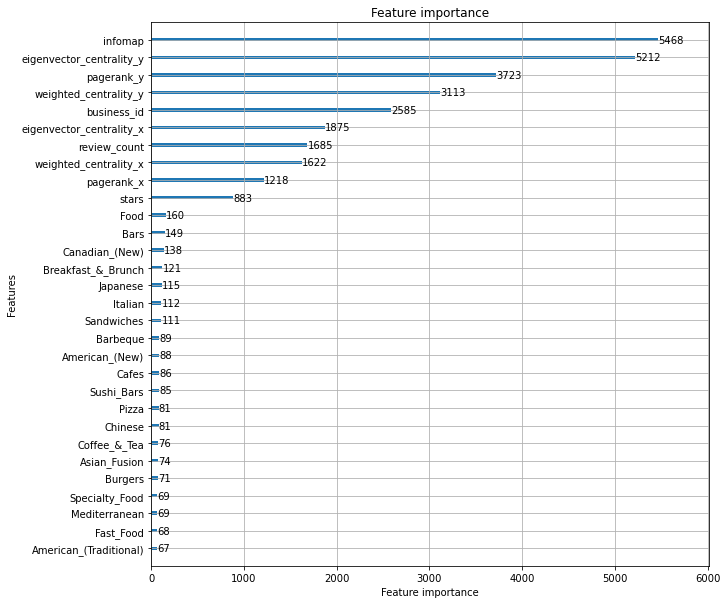

In [63]:
# Feature Importance
lgbm.plot_importance(model, figsize=(10,10), max_num_features=30)

## 2.2 Rating Predictions

In [71]:
# Create X and y
X_train = data_train.drop(['date', 'rating', 'longitude', 'latitude'], axis=1)
y_train = data_train['rating']
q_train = data_train.groupby('user_id')['rating'].count().values

X_val = data_val.drop(['date', 'rating', 'longitude', 'latitude'], axis=1)
y_val = data_val['rating']
q_val = data_val.groupby('user_id')['rating'].count().values

In [72]:
model = lgbm.LGBMClassifier(n_estimators=300, n_jobs=-1, learning_rate=0.01, silent=True)

In [73]:
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [74]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.4235463147083889
Validation Accuracy: 0.42848090201905426


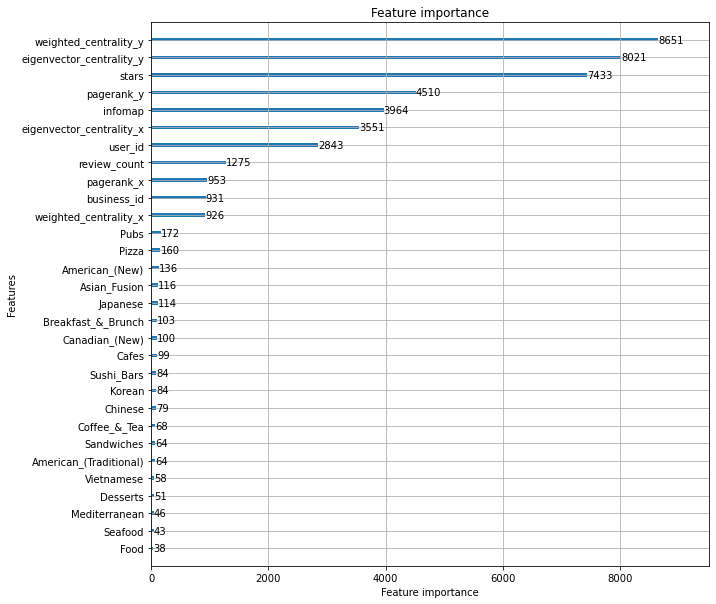

In [75]:
# Feature Importance
lgbm.plot_importance(model, figsize=(10,10), max_num_features=30)